In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

def softmax(x):
    e_x = np.exp(x - np.max(x))
    out = e_x / e_x.sum(axis=0)
    return out

def softmax_grad(x): 
    SM = x.reshape((-1,1))
    jac = np.diagflat(x) - np.dot(SM, SM.T)
    return jac
 
def relu(x):
    return np.maximum(x, 0)

def relu_grad(x):
    return np.greater(x, 0).astype(float)

def sigmoid(x):
    return  1 / (1 + np.exp(-x))

def sigmoid_grad(x):
    return (1 / (1 + np.exp(-x))) * (1 - (1 / (1 + np.exp(-x))))

Activations = {"relu": (relu, relu_grad), "sigmoid": (sigmoid, sigmoid_grad), "softmax": (softmax, softmax_grad)}

class Layer():
    
    def __init__(self, input_size, output_size, activation):
        golrot_r = np.sqrt(6 / (input_size + output_size))
        self.w = np.random.uniform(low = -golrot_r, high = golrot_r, size = (input_size, output_size)) #weights (input_size, output_size)
        self.b = np.random.uniform(low = -golrot_r, high = golrot_r, size = output_size) #bias (output_size, ) -> column vector 1xoutput_size
        self.Z = np.zeros(output_size) #sums of x * W + b -> shape should be (output_size, )
        self.A = np.zeros(output_size) #activated sums = f(Z) -> shape should be (output_size, )
        self.inputs = np.zeros(input_size) #inputs to retrieve in backprop
        self.act, self.act_grad = Activations[activation]
        self.dw = np.zeros_like(self.w)
        self.db = np.zeros_like(self.b)
        self.dZ = np.zeros_like(self.Z)
        self.dA = np.zeros_like(self.A)
        #print(f'init layer with inputs {self.inputs.shape} w {self.w.shape} b {self.b.shape} Z {self.Z.shape} A {self.A.shape}')
    
    def update(self, lr):
        #update the weights and biases, the dW and db come from outside of the layer and are set by the network class
        self.w -= lr * self.dw
        self.b -= lr * self.db
        
    def debug(self, supress_values = True):
        np.set_printoptions(precision=3)
        print("="*20)
        print(f"Inputs: <shape {self.inputs.shape}>")
        if not supress_values: print(self.inputs)
        print(f"Weights: <shape {self.w.shape}>")
        if not supress_values: print(self.w)
        print(f"Biases: <shape {self.b.shape}>")
        if not supress_values: print(self.b)
        print(f"Weighted sums: <shape {self.Z.shape}>")
        if not supress_values: print(self.Z)
        print(f"Output <shape {self.A.shape}>:")
        if not supress_values: print(self.A)
        print("="*20)
        #np.set_printoptions(precision=8)
        
class Network:
    
    def __init__(self, lr=0.01):
        self.layers = []
        self.lr = lr
        
    def add_layer(self, num_of_neurons, *, input_size = None, activation = "relu"):
        if(len(self.layers) == 0):
            assert input_size is not None and input_size > 0, "input_shape needs to be provided in the first layer"
            self.layers.append(Layer(input_size = input_size, output_size = num_of_neurons, activation = activation))
        else:
            if not input_size:
                previous_layer_size = self.layers[-1].w.shape[1]
                self.layers.append(Layer(input_size = previous_layer_size, output_size = num_of_neurons, activation = activation))
            else:
                self.layers.append(Layer(input_size = input_size, output_size = num_of_neurons, activation = activation))
    
    def train(self, X, Y, epochs = 100, verbose = False):
        history = {"loss": [], "accuracy": [], "lr":[]}
        curr_lr = self.lr
        lr_decay= 0.001 / epochs
        start_time = time.time()
        for epoch in range(epochs):
            epoch_loss = 0.0
            for x, y in zip(X, Y):
                prediction = self.feedforward(x)
                epoch_loss += self.cost(prediction, y)
                self.backpropagate(prediction, y)
                self.update_weights(curr_lr)
            history["loss"].append(epoch_loss)
            history["accuracy"].append(self.evaluate(X, Y))
            history["lr"].append(curr_lr)
            curr_lr = curr_lr * 1/(1 + lr_decay * epoch)
            if(verbose):
                print(f'[Epoch {epoch + 1}] Loss {epoch_loss:.5f}. Accuracy {self.evaluate(X, Y):.5f}')
        print(f'Finished training in {time.time() - start_time:.2f} s. Final loss {epoch_loss:.5f}. Final accuracy {self.evaluate(X, Y):.5f}')
        return history
    
    def predict(self, X):
        predictions = []
        for x in X:
            prediction = self.feedforward(x)
            predictions.append(prediction)
            #print(f'{x} -> {prediction}')
        predictions = np.array(predictions)
        return predictions
    
    def evaluate(self, X, Y):
        Y = np.argmax(Y, axis=1)
        predictions = self.predict(X)
        correct = 0
        predictions = np.argmax(predictions, axis=1)
        for prediction, true in zip(predictions, Y):
            if(prediction == true):
                correct += 1
        acc = 100.0*correct/len(Y)
        return acc
    
    def feedforward(self, _input):
        _in = _input
        for L in self.layers:
            L.inputs = _in
            L.Z = np.dot(L.inputs, L.w) + L.b
            L.A = L.act(L.Z)
            _in = L.A
        return _in
    
    def backpropagate(self, prediction, true_label):
        '''
        A(L-1) = inputs
        dZ(L) = A(L) - Y
        dW(L) = dZ(L) * 
        
        ∂E/∂Y - given from cost_prime or is ∂i from previous layers 
        ∂E/∂Wij = ∂E/∂y1 * ∂y1/∂Wij + ... + ∂E/∂yj * ∂yj/∂Wij and since ∂yj/∂Wij = xi then
            ∂E/∂Wij = ∂E/∂yj * xi
            
        therefore ∂E/∂W (all weights) = [∂E/∂y1 x1 ... ∂E/∂yj x1      [x1]
                                            ...                       |  |
                                                                    = |..| [∂E/∂y1 ... ∂E/∂yj] = X.T * ∂E/∂Y
                                        ∂E/∂y1 xi ... ∂E/∂yj xi]      [xi]
        ∂E/∂W = X.T * ∂E/∂Y -> weights error 
        ∂E/∂B = ∂E/∂Y   - bias error
        ∂E/∂X = ∂E/∂Y * W.T  - ∂i -> to pass to previous layers
        
        
        for activation layers (embedded) - we have to reverse the activation function first
        ∂E/∂X = [∂E/∂X1, ... ∂E/∂Xi] = [∂E/∂y1 * ∂y1/∂x1 ... ∂E/∂yi * ∂yi/∂xi] = [∂E/∂y1 * f'(x1) ... ∂E/∂yi * f'(xi)]
        = [∂E/∂y1... ∂E/∂yi] *(ELEMENTWISE) [f'(x1) .. f'(xi)] = ∂E/∂Y *(ELEMENTWISE) f'(X)
        '''
        output_layer = self.layers[-1]
        
        output_layer.dZ = self.cost_grad(prediction, true_label)
        output_layer.dw = np.outer(output_layer.inputs, output_layer.dZ)
        output_layer.db = output_layer.dZ
        
        for i in range(len(self.layers)-2, -1, -1):
            self.layers[i].dA = self.layers[i+1].dZ @ self.layers[i+1].w.T
            self.layers[i].dZ = self.layers[i].dA * self.layers[i].act_grad(self.layers[i].Z)
            self.layers[i].dW = np.outer(self.layers[i].dZ, self.layers[i].inputs)
            self.layers[i].db = self.layers[i].dZ
        
    
    def update_weights(self, lr):
        for layer in self.layers:
            layer.update(self.lr)
    
    def cost(self, predictions, targets):
        #MSE cost implementation = 1/n * sum(1, n) [(predictions - targets)^2]
        return np.square(np.subtract(predictions, targets)).mean()
    
    def cost_grad(self, predictions, targets):
        #MSE derivative of cost w.r.t the activated sums of the last layer
        return np.subtract(predictions, targets)
    
    def summary(self):
        print(f'Network with {len(self.layers)} layers')
        for i, layer in enumerate(self.layers):
            print(f'[Layer {i+1}] Input {layer.inputs.shape} -> Weights {layer.w.shape} -> Output {layer.A.shape}')

            
def plot_history(history, include_lr = False):
    fig, axs = plt.subplots(1, 3, figsize=(16,4))
    axs[0].plot(history['accuracy'], label='accuracy')
    axs[1].plot(history['loss'], label='loss')
    axs[0].set_title('Accuracy')
    axs[1].set_title('Loss')
    if(include_lr): 
        axs[2].plot(history['lr'], label='learning rate')
        axs[2].set_title('Learning rate')


Network with 2 layers
[Layer 1] Input (2,) -> Weights (2, 5) -> Output (5,)
[Layer 2] Input (5,) -> Weights (5, 4) -> Output (4,)
Finished training in 0.36 s. Final loss 5.54544. Final accuracy 88.00000


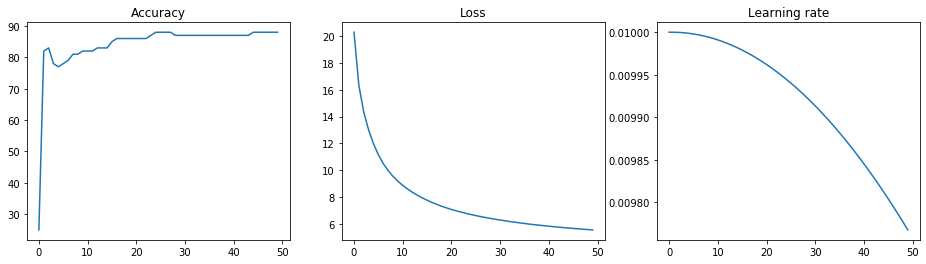

In [2]:
from sklearn.datasets import make_classification, load_iris, load_digits
from keras.utils import to_categorical

X, y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, n_classes=4, n_clusters_per_class=1)
y = to_categorical(y)
net = Network(lr = 0.01)
net.add_layer(5, input_size = 2, activation = 'relu')
net.add_layer(4, activation = 'softmax')
net.summary()
history = net.train(X, y, epochs=50)
plot_history(history, include_lr = True)

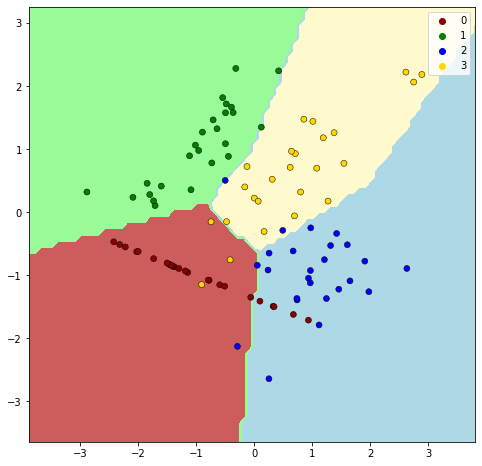

In [3]:

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
plt.figure(figsize = (8, 8))
Z = net.predict(np.c_[xx.ravel(), yy.ravel()])

Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, cmap=ListedColormap(['indianred', 'palegreen', 'lightblue', 'lemonchiffon']))
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=np.argmax(y, axis=1), palette=['darkred', 'green', 'blue', 'gold'], alpha=1.0, edgecolor="black")

In [12]:
import pandas as pd

name_to_number = {'setosa': [1., 0., 0.], 'versicolor': [0., 1., 0.], 'virginica': [0., 0., 1.]}

iris_csv = pd.read_csv('iris.csv')
X_sepal = iris_csv.to_numpy()[: , :2].astype(float)
X_petal = iris_csv.to_numpy()[: , 2:4].astype(float)
X = iris_csv.to_numpy()[: , :4].astype(float)
Y = iris_csv.to_numpy()[:, -1]
Y = np.array([name_to_number[i] for i in Y])
#X_sepal, y_sepal = dataset.data[:, :2], to_categorical(dataset.target)
#X_petal, y_petal = dataset.data[:, 2:], to_categorical(dataset.target)

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0

Finished training in 20.13 s. Final loss 11.86580. Final accuracy 70.00000


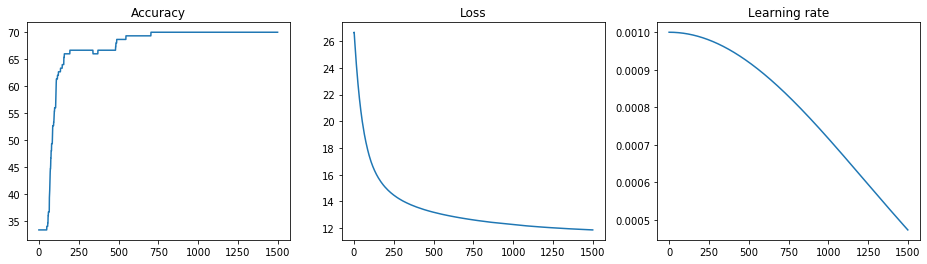

In [13]:
net = Network(lr = 0.001)
net.add_layer(8, input_size = 2, activation = 'relu')
net.add_layer(12)
net.add_layer(3, activation = 'softmax')
history = net.train(X_sepal, Y, epochs=1500)
plot_history(history, include_lr = True)

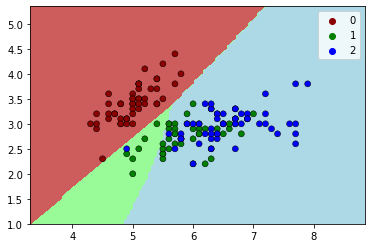

In [14]:
x_min, x_max = X_sepal[:, 0].min() - 1, X_sepal[:, 0].max() + 1
y_min, y_max = X_sepal[:, 1].min() - 1, X_sepal[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05),
                     np.arange(y_min, y_max, 0.05))
Z = net.predict(np.c_[xx.ravel(), yy.ravel()])
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, cmap=ListedColormap(['indianred', 'palegreen', 'lightblue']))
sns.scatterplot(x=X_sepal[:, 0], y=X_sepal[:, 1], hue=np.argmax(Y, axis = 1), palette=['darkred', 'green', 'blue'], alpha=1.0, edgecolor="black")

In [15]:
net = Network(lr = 0.001)
net.add_layer(12, input_size = 4, activation = 'relu')
net.add_layer(8)
net.add_layer(3, activation = 'softmax')
history = net.train(X, Y, epochs=500, verbose=False)



Finished training in 6.74 s. Final loss 4.35944. Final accuracy 96.66667


(1797, 64) (1797, 10)
[Epoch 1] Loss 73.46467. Accuracy 83.36116
[Epoch 2] Loss 35.24131. Accuracy 87.75737
[Epoch 3] Loss 26.70420. Accuracy 86.36617
[Epoch 4] Loss 23.40121. Accuracy 87.97997
[Epoch 5] Loss 19.25116. Accuracy 85.36450
[Epoch 6] Loss 16.90473. Accuracy 87.03395
[Epoch 7] Loss 16.68240. Accuracy 85.14190
[Epoch 8] Loss 15.04201. Accuracy 88.53645
[Epoch 9] Loss 14.49844. Accuracy 86.92265
[Epoch 10] Loss 12.86708. Accuracy 88.09126
[Epoch 11] Loss 11.33857. Accuracy 88.31386
[Epoch 12] Loss 11.19716. Accuracy 88.20256
[Epoch 13] Loss 10.76433. Accuracy 88.70339
[Epoch 14] Loss 10.07146. Accuracy 91.20757
[Epoch 15] Loss 9.76759. Accuracy 92.37618
[Epoch 16] Loss 9.53313. Accuracy 93.21091
[Epoch 17] Loss 9.29704. Accuracy 94.65776
[Epoch 18] Loss 9.20902. Accuracy 95.10295
[Epoch 19] Loss 8.83127. Accuracy 95.54814
[Epoch 20] Loss 8.23226. Accuracy 95.82638
[Epoch 21] Loss 8.08992. Accuracy 95.88203
[Epoch 22] Loss 8.05262. Accuracy 95.88203
[Epoch 23] Loss 8.04126. Ac

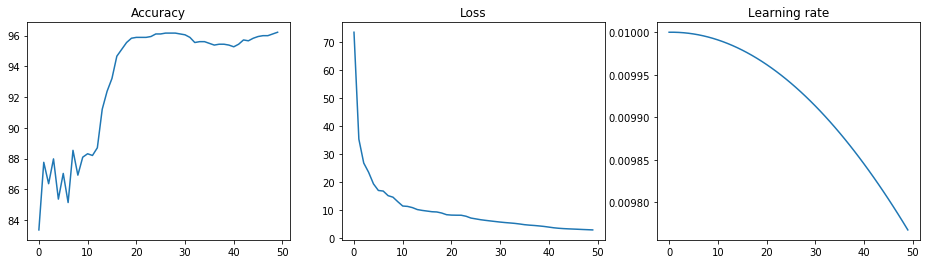

In [16]:
mnist = load_digits()
X, y = mnist.data, mnist.target
y = to_categorical(y)
print(X.shape, y.shape)

net = Network(lr = 0.01)
net.add_layer(128, input_size = 64, activation = 'relu')
net.add_layer(64)
net.add_layer(10, activation = 'softmax')
history = net.train(X, y, epochs = 50, verbose=True)
plot_history(history, include_lr = True)